In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)

In [2]:
cutoff <- 0.05

# Load data

In [3]:
reference_df <- vroom::vroom("../data/igap//IGAP_stage_1.txt", show_col_types = F, delim = "\t",
                             col_select = c(Chromosome, Position, Pvalue)) %>%
    rename(P_ref = Pvalue) %>%
    mutate(
        ID = str_glue("{Chromosome}:{Position}") %>% as.character(),
        truth = factor(P_ref < cutoff, levels = c("TRUE", "FALSE"))
    ) %>%
    select(ID, P_ref, truth)

reference_df %>% head(2)

ID,P_ref,truth
<chr>,<dbl>,<fct>
1:751343,0.6651,FALSE
1:751756,0.6651,FALSE


In [4]:
naive_df <- fs::dir_ls("data/gwas/", glob = "*naive.*b_I63.glm.linear") %>%
    vroom::vroom(
        id = "source", col_select = c("ID", "P"), show_col_types = F,
        col_types = cols(ID = col_character(), P = col_double())
    ) %>%
    mutate(phenotype_id = str_extract(source, "(?<=naive\\.).+(?=\\.glm\\.linear)")) %>%
    select(phenotype_id, ID, P)

naive_df %>% head(2)

phenotype_id,ID,P
<chr>,<chr>,<dbl>
b_I63,1:752566,0.519455
b_I63,1:752721,0.459446


In [5]:
maxgcp_df <- fs::dir_ls("data/gwas/", glob = "*maxgcp*.glm.linear.zst") %>%
    map(
        ~read_tsv_arrow(.x, col_types = schema(ID = utf8(), P = float64())) %>% 
        mutate(phenotype_id = str_extract(.x, "(?<=maxgcp\\.).+(?=\\.glm)"))
    ) %>%
    list_rbind %>%
    select(phenotype_id, ID, P) %>%
    mutate(mega_type = phenotype_id %>% str_extract("full|sum"))

maxgcp_df %>% head(2)

phenotype_id,ID,P,mega_type
<chr>,<chr>,<dbl>,<chr>
maxgcp_full,1:752566,0.846883,full
maxgcp_full,1:752721,0.834319,full


# Perform comparison

In [6]:
raw_comparison_df <- bind_rows(
        reference_df %>%
            inner_join(maxgcp_df, by = c("ID")),
        reference_df %>%
            inner_join(naive_df, by = c("ID"))
    ) %>%
    mutate(
        estimate = factor(P < cutoff, levels = c("TRUE", "FALSE")),
        phenotype_id = phenotype_id %>% 
            recode_factor(
                maxgcp_full = "MaxGCP (N=350k)",
                b_I63 = "Naive (N=350k)",
                maxgcp_sub = "MaxGCP (N=15k)",
                sub_b_I63 = "Naive (N=15k)",                
            ),
    )

raw_comparison_df %>% head(2)

ID,P_ref,truth,phenotype_id,P,mega_type,estimate
<chr>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>
1:752566,0.6773,FALSE,MaxGCP (N=350k),0.846883,full,FALSE
1:752566,0.6773,FALSE,MaxGCP (N=15k),0.970411,NA,FALSE


In [7]:
summary_df <- raw_comparison_df %>%
    group_by(phenotype_id) %>%
    summarize(
        n_variants = n(),
        n_true = sum(truth == "TRUE"),
        n_estimated = sum(estimate == "TRUE"),
        n_true_positives = sum(truth == "TRUE" & estimate == "TRUE"),
        sensitivity = sensitivity_vec(truth, estimate),
        specificity = specificity_vec(truth, estimate),
        auroc = roc_auc_vec(truth, -log10(P)),
        f1 = f_meas_vec(truth, estimate),
        .groups = "drop"
    )

summary_df %>% write_parquet("plot_data/summary.parquet")

In [8]:
roc_df <- raw_comparison_df %>%
    group_by(phenotype_id) %>%
    mutate(nlogp = -log10(P)) %>%
    roc_curve(truth, nlogp)

roc_df %>% write_parquet("plot_data/roc_curves.parquet")

In [9]:
target_sensitivity_specificity_df <- bind_rows(
    roc_df %>%
        filter(specificity >= 0.9) %>%
        filter(.threshold == min(.threshold)) %>%
        mutate(metric = "Sensitivity\n(at 90% specificity)") %>%
        select(phenotype_id, metric, value = sensitivity),
    roc_df %>%
        filter(sensitivity >= 0.1) %>%
        filter(.threshold == max(.threshold)) %>%
        mutate(metric = "Specificity\n(at 10% sensitivity)") %>%
        select(phenotype_id, metric, value = specificity)
)

target_sensitivity_specificity_df %>% 
    write_parquet("plot_data/target_sensitivity_specificity.parquet")

# Plot results

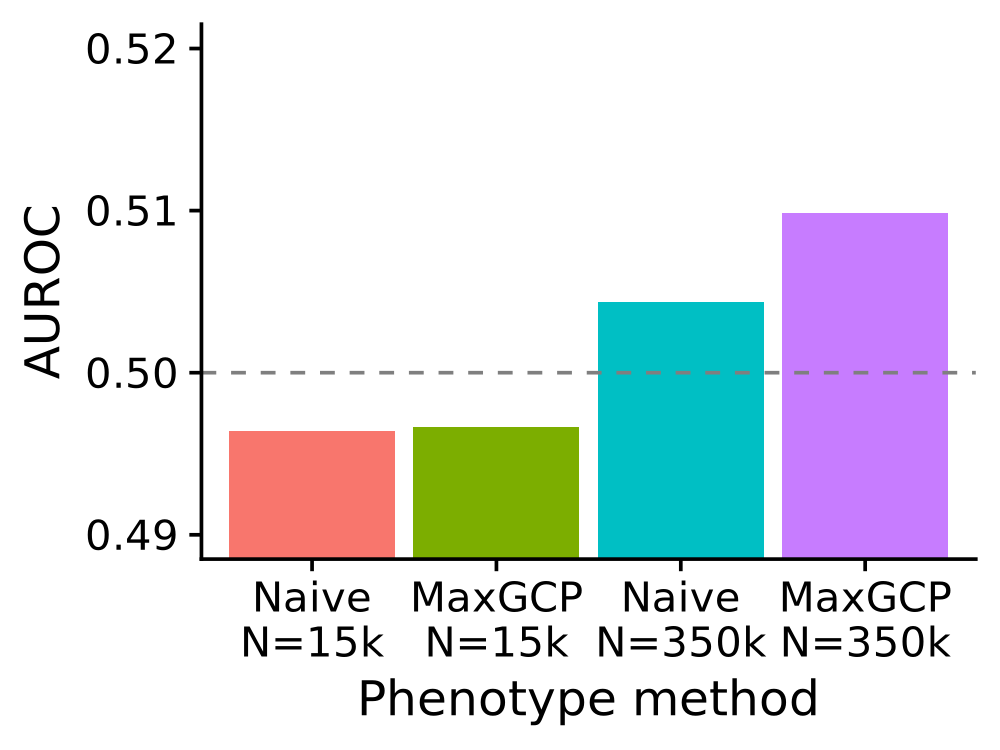

In [10]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250)

summary_df <- read_parquet("plot_data/summary.parquet") %>%
    mutate(
        cohort = phenotype_id %>% str_extract("[0-9]+k"),
        phenotype_id = phenotype_id %>% 
            str_remove_all("\\(|\\)") %>% 
            str_replace(" ", "\n") %>%
            fct_reorder(auroc)
    )

summary_df %>%
    ggplot(aes(x = phenotype_id, y = auroc, fill = phenotype_id)) +
    geom_col() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    theme(
        legend.position = "none",
    ) +
    xlab("Phenotype method") +
    ylab("AUROC") +
    coord_cartesian(ylim = c(0.49, 0.52))

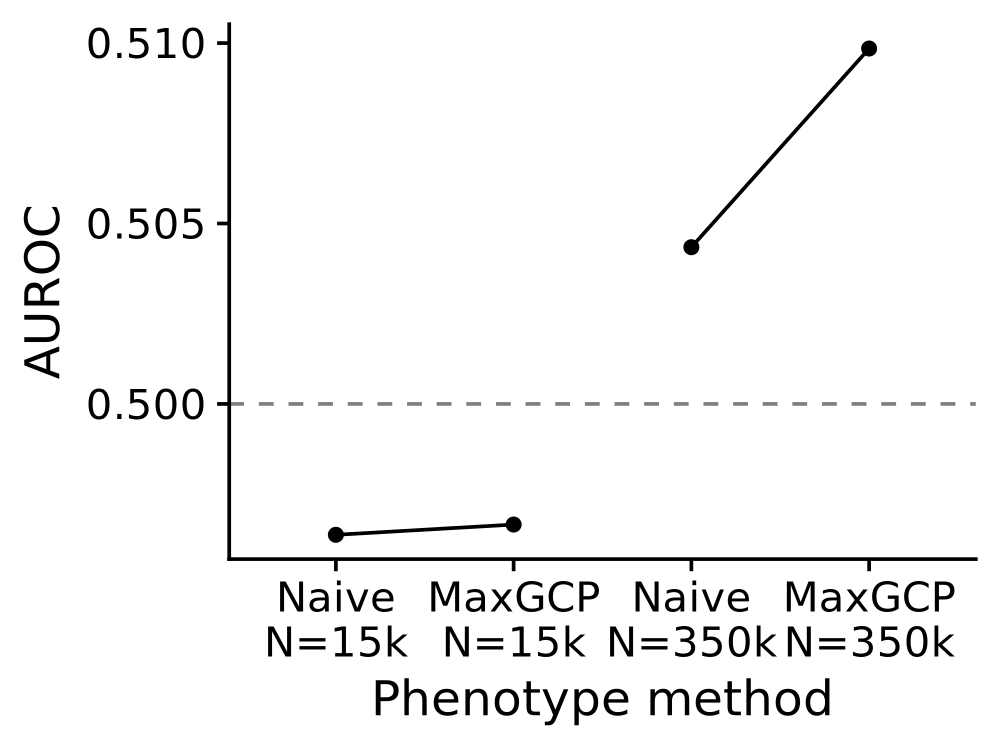

In [11]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250)

auroc_plot <- summary_df %>%
    ggplot(aes(x = phenotype_id, y = auroc, group = cohort)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    theme(
        legend.position = "none",
    ) +
    xlab("Phenotype method") +
    ylab("AUROC")

save_plot("img/auroc.png", auroc_plot, base_width = 4, base_height = 3, dpi = 400)

auroc_plot

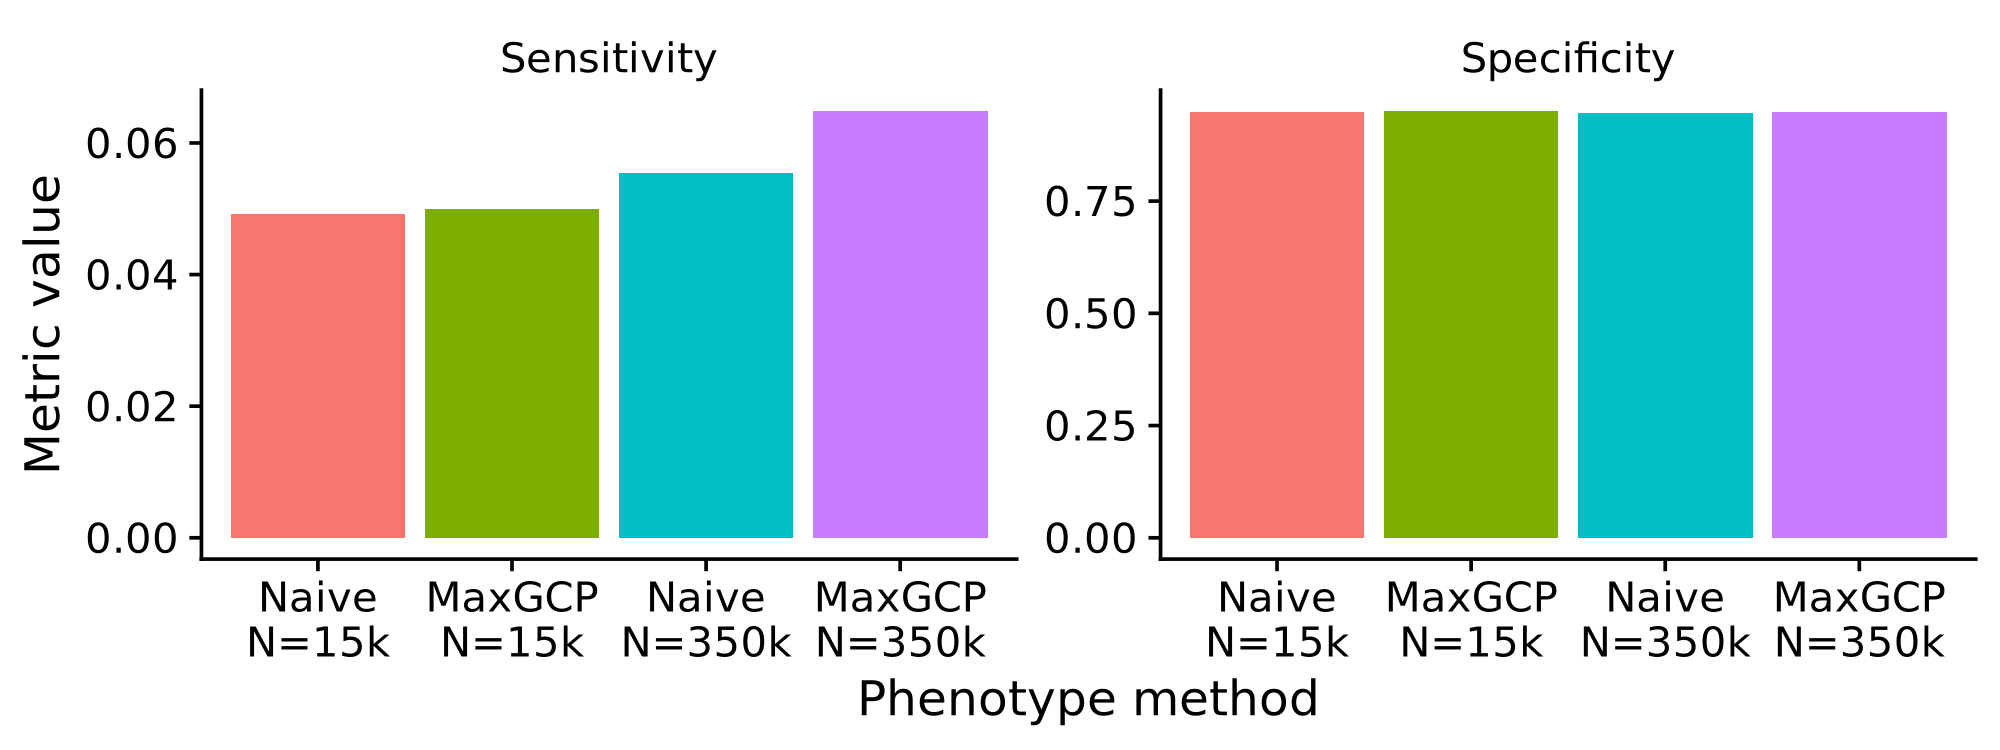

In [12]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 250)

summary_df %>%
    pivot_longer(c(sensitivity, specificity), names_to = "metric") %>%
    mutate(metric = metric %>% str_to_sentence) %>%
    ggplot(aes(x = phenotype_id, y = value, fill = phenotype_id)) +
    geom_col() +
    facet_wrap(vars(metric), scales = "free_y") +
    theme_cowplot() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    xlab("Phenotype method") +
    ylab("Metric value")

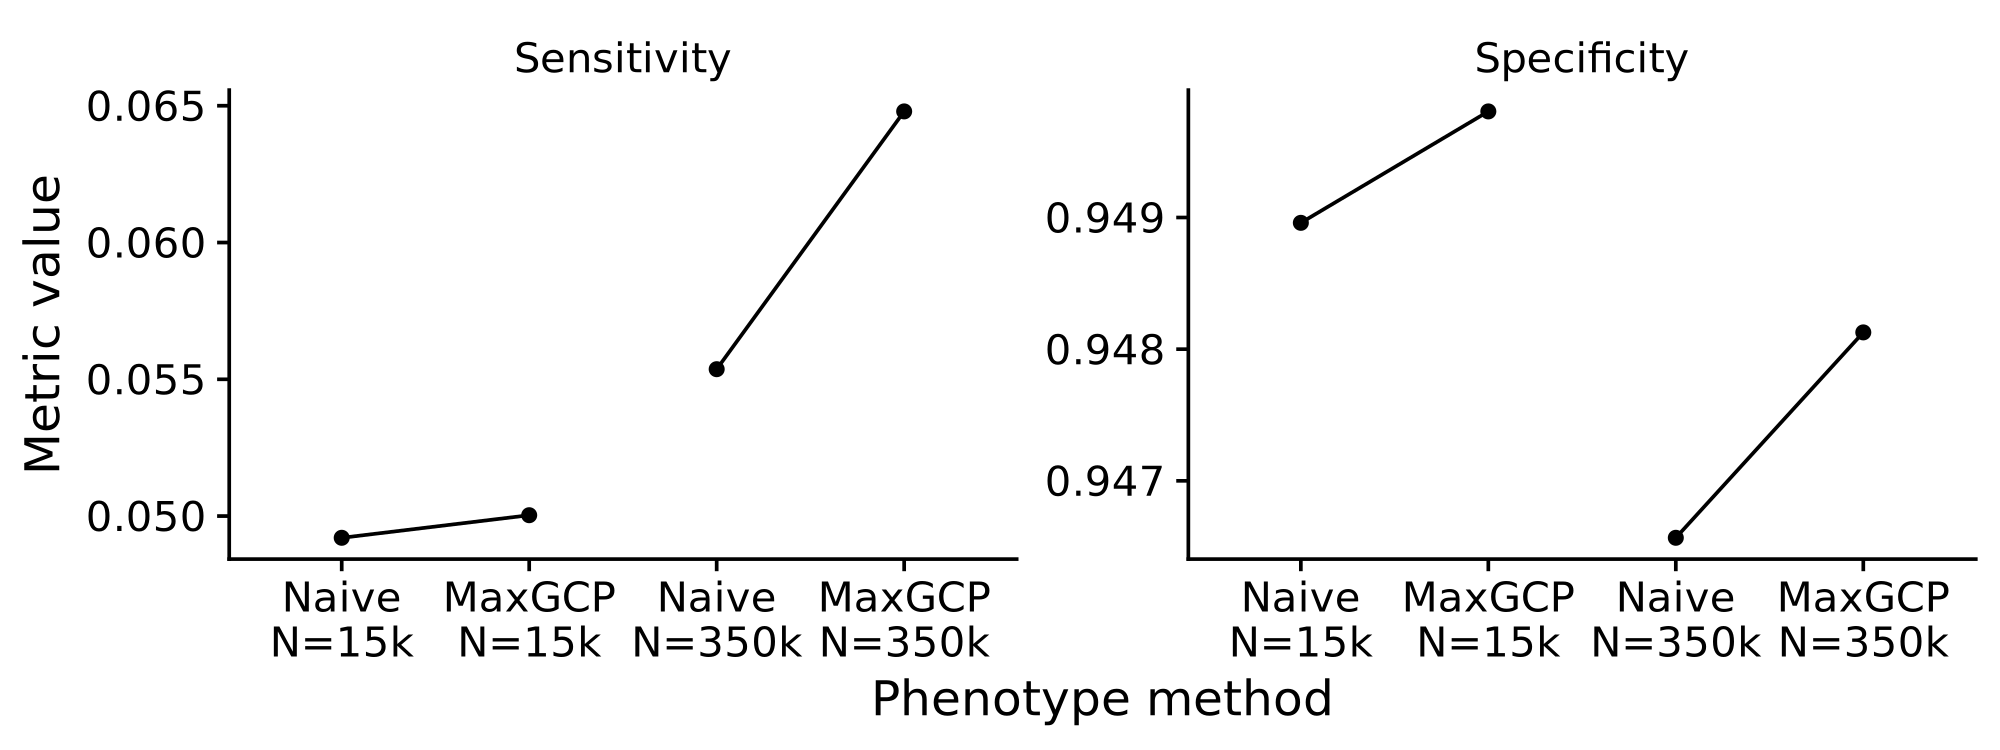

In [13]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 250)

sens_spec_plot <- summary_df %>%
    pivot_longer(c(sensitivity, specificity), names_to = "metric") %>%
    mutate(
        metric = metric %>% str_to_sentence,
        cohort = phenotype_id %>% str_extract("[0-9]+k")
    ) %>%
    ggplot(aes(x = phenotype_id, y = value, group = cohort)) +
    geom_line() +
    geom_point() +
    facet_wrap(vars(metric), scales = "free_y") +
    theme_cowplot() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    xlab("Phenotype method") +
    ylab("Metric value")

save_plot("img/sens_spec.png", sens_spec_plot, base_width = 8, base_height = 3, dpi = 400)

sens_spec_plot

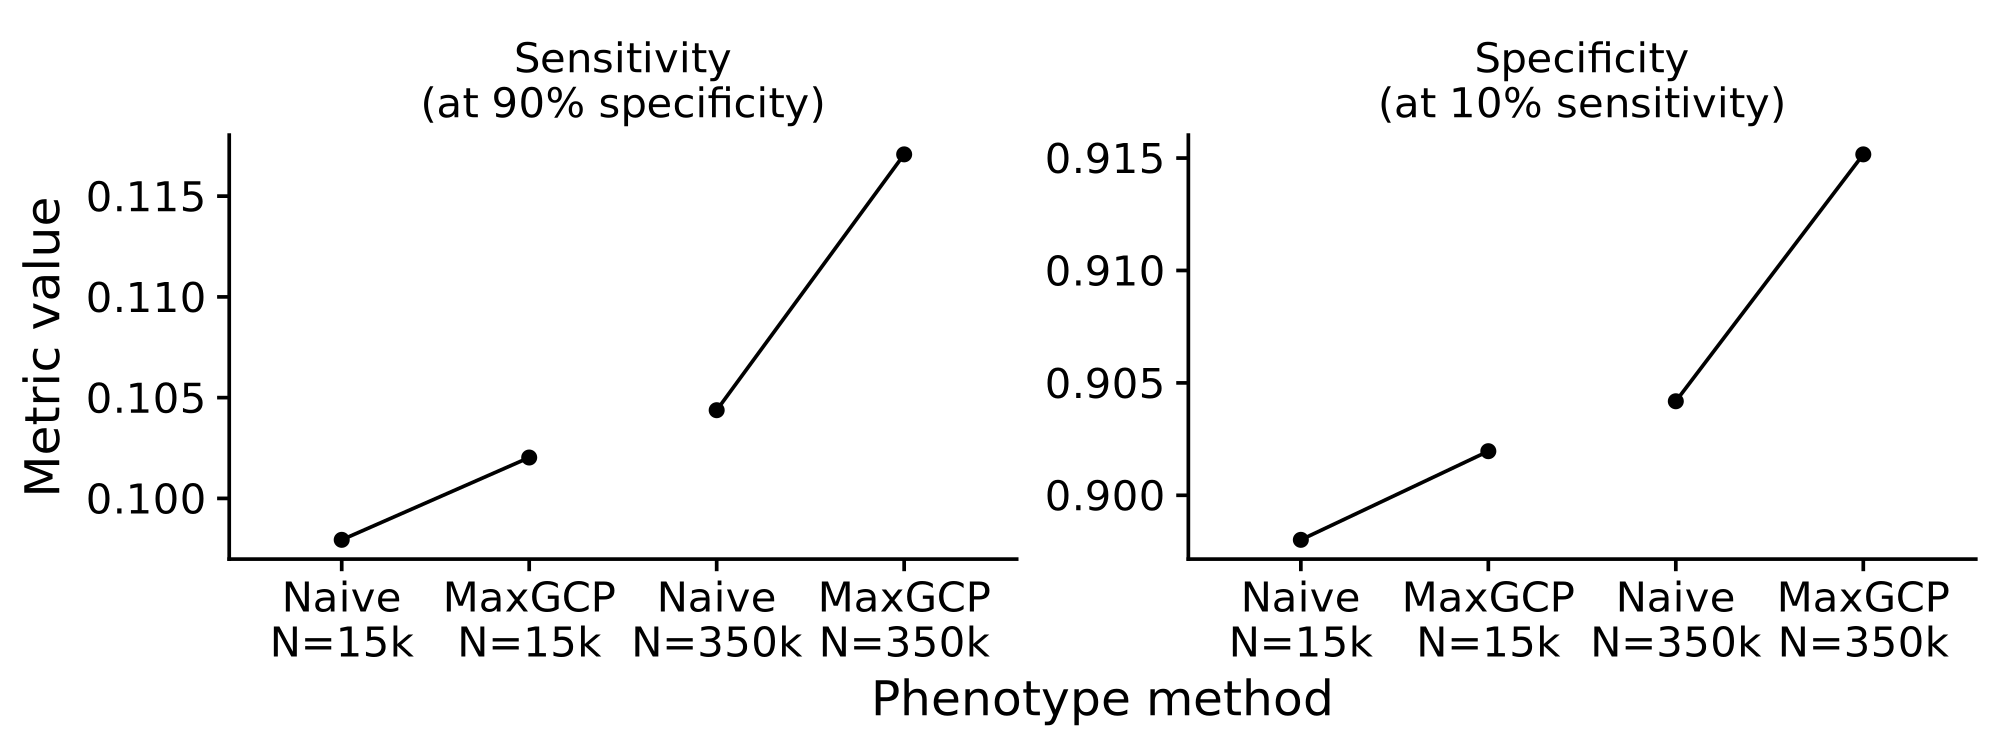

In [14]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 250)

target_sensitivity_specificity_df <- read_parquet(
    "plot_data/target_sensitivity_specificity.parquet")

target_sens_spec_plot <- target_sensitivity_specificity_df %>%
    mutate(
        cohort = phenotype_id %>% str_extract("[0-9]+k"),
        phenotype_id = phenotype_id %>% 
            str_remove_all("\\(|\\)") %>% 
            str_replace(" ", "\n") %>%
            factor(levels = c("Naive\nN=15k", "MaxGCP\nN=15k", "Naive\nN=350k", "MaxGCP\nN=350k"))
    ) %>%
    ggplot(aes(x = phenotype_id, y = value, group = cohort)) +
    geom_line() +
    geom_point() +
    facet_wrap(vars(metric), scales = "free_y") +
    theme_cowplot() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    xlab("Phenotype method") +
    ylab("Metric value")

save_plot("img/target_sens_spec.png", target_sens_spec_plot, base_width = 8, base_height = 3, dpi = 400)

target_sens_spec_plot